# Credit default risk model

The following is my code for a Data Science Case. It contains comments, but the main analysis and summary is found in a separate document. It is structured in the following sections:

1. Setup
2. Data exploration
3. Data cleaning and feature engineering
4. Models and metrics

## Setup

Here we load the necessary libraries, as well as the data from the database (as a Pandas dataframe).

In [3]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
import json
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV

In [4]:
with open('config.json') as f:
    conf = json.load(f)

In [5]:
host = conf['host']
database = conf['database']
user = conf['user']
passw = conf['passw']

In [6]:
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)

In [7]:
conn = psycopg2.connect(conn_str)

In [8]:
df = pd.read_sql('SELECT * FROM creditdataset', con=conn)

## Data exploration

Here we form a general impression of the data, by looking at examples of data entries, the kinds of columns we have, elementary statistics on the column values, and then histograms to illustrate the relationship of each feature with the target. I am going to assume that the features are reasonable named (so that for instance the 'income_tax' feature represents the income tax paid by the customer during a certain period). Finally, we look closer at some particular features where further analysis seems warranted.

In [9]:
df.head(100)

,id,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,creditors_count,income_employment,has_spouce,customer_age,credit_used_instalment,capital_deduction,inquiries_count,credit_used_blanco,payment_remarks_amount,e_mal_active_amount,a_mal_active_amount,debt_requests_count,housing_rent,blanco_amount,credit_card_amount,housing_base_cost,inquiries_count_12m,big_city,credit_used_account,day,hour_1,contact_channel,email_domain,lender_id,customer_postal,loan_interest,loan_fee,loan_type,target
0,0eedb807-e20b-41e2-be30-9a60f7dbdb7a,19.33400,57500.0,204080.0,0.0,0.0,8.0,238800.0,0.0,260400.0,214302.0,6.0,260400.0,0.0,35.0,0.0,21600.0,8.0,132302.0,0.0,0.0,0.0,0.0,5983.33,132302.0,71778.0,3500.0,8.0,False,71778.0,28.0,17.0,7.0,11.0,13.0,65224.0,19.90,29.0,pos,1.0
1,318d2ac4-b724-4691-b148-5ae0b5859953,0.60314,45400.0,367.0,0.0,0.0,1.0,216800.0,0.0,216900.0,367.0,1.0,216800.0,0.0,23.0,367.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5983.33,0.0,0.0,3500.0,0.0,False,0.0,16.0,19.0,7.0,1.0,77.0,73141.0,19.90,29.0,pos,0.0
2,6da47c66-2933-4b26-8847-c4d1d4c8fcc5,30.46367,43500.0,579783.0,0.0,0.0,13.0,221000.0,0.0,276600.0,585991.0,9.0,276500.0,0.0,36.0,25106.0,55500.0,46.0,541885.0,0.0,0.0,0.0,0.0,5983.33,541885.0,12792.0,3500.0,46.0,False,12792.0,18.0,15.0,7.0,2.0,86.0,79252.0,133.57,0.0,blanco-,1.0
3,26563d53-e703-4437-a500-d9f54b05bffd,33.22719,47000.0,315891.0,0.0,0.0,9.0,205000.0,0.0,278900.0,336012.0,6.0,278900.0,1.0,30.0,0.0,73900.0,45.0,251012.0,0.0,0.0,0.0,0.0,5983.33,251012.0,64879.0,3500.0,45.0,False,64879.0,6.0,22.0,7.0,1.0,13.0,NaN,19.90,29.0,pos,1.0
4,7ecf362c-9fb4-4b22-a890-91c8862e74ae,24.68127,3600.0,1033.0,0.0,0.0,1.0,46000.0,0.0,46600.0,1033.0,1.0,46500.0,0.0,24.0,1033.0,500.0,22.0,0.0,0.0,0.0,0.0,0.0,5983.33,0.0,0.0,3500.0,22.0,False,0.0,27.0,14.0,7.0,3.0,13.0,NaN,19.90,29.0,pos,1.0
5,c3e71d43-1525-4128-883a-4d5c7bf0fe54,34.60305,7400.0,73641.0,0.0,0.0,2.0,78700.0,0.0,85400.0,75050.0,2.0,85400.0,0.0,26.0,0.0,6700.0,12.0,60050.0,0.0,0.0,0.0,0.0,5983.33,60050.0,13591.0,3500.0,12.0,False,13591.0,18.0,18.0,7.0,2.0,78.0,11423.0,116.00,0.0,blanco-,1.0
6,07f30954-7d8b-409b-a188-6b67f6f3c812,1.10269,95400.0,237072.0,0.0,0.0,5.0,379100.0,0.0,384000.0,271135.0,5.0,383900.0,0.0,31.0,128779.0,4800.0,1.0,62356.0,0.0,0.0,0.0,0.0,5983.33,62356.0,45937.0,3500.0,1.0,False,45937.0,15.0,22.0,7.0,2.0,167.0,12432.0,15.90,0.0,cc,0.0
7,19d9c39d-d33d-4045-bdd2-e89decee609d,0.07606,59000.0,3615654.0,0.0,0.0,11.0,246900.0,0.0,292600.0,3655520.0,5.0,292600.0,0.0,29.0,758.0,45700.0,4.0,0.0,0.0,0.0,0.0,0.0,5983.33,0.0,134.0,3500.0,4.0,False,134.0,24.0,10.0,1.0,14.0,77.0,76165.0,19.90,29.0,pos,0.0
8,c781b398-f4b8-431a-9cc8-c689d9be5bfd,12.05540,33700.0,5404.0,0.0,0.0,1.0,177400.0,0.0,177900.0,24800.0,1.0,177800.0,0.0,24.0,0.0,400.0,13.0,0.0,0.0,0.0,0.0,0.0,5983.33,0.0,5404.0,3500.0,13.0,False,5404.0,13.0,21.0,7.0,2.0,13.0,70362.0,19.90,29.0,pos,0.0
9,99d00e79-b77b-4402-9432-a20a0202ca6c,29.33418,10600.0,20749.0,0.0,0.0,2.0,91000.0,0.0,94100.0,21153.0,2.0,94100.0,0.0,20.0,11153.0,3100.0,17.0,0.0,0.0,0.0,0.0,0.0,5983.33,0.0,9596.0,3500.0,17.0,False,9596.0,31.0,22.0,7.0,1.0,13.0,21219.0,19.90,29.0,pos,1.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 40 columns):
id                        1200 non-null object
external_score            1200 non-null float64
income_tax                1199 non-null float64
credit_used               1200 non-null float64
e_mal_count               1200 non-null float64
a_mal_count               1200 non-null float64
credit_count              1200 non-null float64
income_gross              1200 non-null float64
capital_income            1200 non-null float64
salary_surplus            1200 non-null float64
credit_approved           1200 non-null float64
creditors_count           1200 non-null float64
income_employment         1199 non-null float64
has_spouce                1200 non-null float64
customer_age              1200 non-null float64
credit_used_instalment    1200 non-null float64
capital_deduction         1200 non-null float64
inquiries_count           1200 non-null float64
credit_used_blanco        1200

In [11]:
df.describe()

,external_score,income_tax,credit_used,e_mal_count,a_mal_count,credit_count,income_gross,capital_income,salary_surplus,credit_approved,creditors_count,income_employment,has_spouce,customer_age,credit_used_instalment,capital_deduction,inquiries_count,credit_used_blanco,payment_remarks_amount,e_mal_active_amount,a_mal_active_amount,debt_requests_count,housing_rent,blanco_amount,credit_card_amount,housing_base_cost,inquiries_count_12m,credit_used_account,day,hour_1,contact_channel,email_domain,lender_id,customer_postal,loan_interest,loan_fee,target
count,1200.000000,1199.000000,1.200000e+03,1200.000000,1200.000000,1200.000000,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1200.000000,1.199000e+03,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.00000,1200.000000,1200.0,1.199000e+03,1.199000e+03,1199.000000,1199.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1040.000000,1200.000000,1200.000000,1200.000000
mean,11.263577,56284.403670,7.081267e+05,0.058333,0.003333,6.091667,2.300869e+05,3.283833e+03,2.434728e+05,7.259532e+05,4.458333,2.457641e+05,0.236667,31.729167,17696.878333,19286.666667,9.658333,1.631939e+05,1218.949167,436.22750,89.677500,0.0,5.983330e+03,1.632794e+05,26141.188490,3500.0,9.658333,26226.438333,18.570000,13.604167,5.551667,5.725000,45.864167,46801.670192,22.983700,20.400750,0.350000
std,16.420758,52965.539229,1.126815e+06,1.068901,0.057663,4.524230,1.535522e+05,4.399655e+04,1.514555e+05,1.136383e+06,2.919823,1.525511e+05,0.425213,9.620531,52803.947319,28342.165364,14.454782,2.627769e+05,14680.317182,8675.31801,2658.734619,0.0,6.096157e-11,2.628699e+05,39756.683027,0.0,14.454782,39849.675382,8.188568,5.270417,2.547431,5.651046,50.091883,26462.164683,33.742204,14.874686,0.477168
min,0.010520,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.0,5.983330e+03,0.000000e+00,0.000000,3500.0,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,12.000000,7032.000000,0.000000,0.000000,0.000000
25%,1.157820,23900.000000,3.066850e+04,0.000000,0.000000,3.000000,1.281250e+05,0.000000e+00,1.377250e+05,3.995825e+04,2.000000,1.397000e+05,0.000000,25.000000,0.000000,1600.000000,2.000000,0.000000e+00,0.000000,0.00000,0.000000,0.0,5.983330e+03,0.000000e+00,0.000000,3500.0,2.000000,0.000000,13.000000,10.000000,7.000000,1.000000,13.000000,21437.750000,16.990000,0.000000,0.000000
50%,3.503290,51500.000000,2.262270e+05,0.000000,0.000000,5.000000,2.290000e+05,0.000000e+00,2.448500e+05,2.367225e+05,4.000000,2.475000e+05,0.000000,29.000000,727.500000,8400.000000,5.000000,7.086300e+04,0.000000,0.00000,0.000000,0.0,5.983330e+03,7.099600e+04,11895.000000,3500.0,5.000000,11937.500000,20.000000,14.000000,7.000000,2.000000,20.000000,44887.500000,19.900000,29.000000,0.000000
75%,14.811427,72500.000000,9.005428e+05,0.000000,0.000000,9.000000,3.045750e+05,0.000000e+00,3.276000e+05,9.105708e+05,6.000000,3.278000e+05,0.000000,37.000000,6747.000000,27125.000000,10.000000,2.456845e+05,0.000000,0.00000,0.000000,0.0,5.983330e+03,2.459280e+05,37344.000000,3500.0,10.000000,37401.250000,25.000000,18.000000,7.000000,14.000000,74.000000,71133.250000,19.900000,29.000000,1.000000
max,94.954950,841900.000000,1.048949e+07,31.000000,1.000000,30.000000,1.749600e+06,1.030400e+06,1.784600e+06,1.051175e+07,16.000000,1.784500e+06,1.000000,76.000000,537022.000000,376400.000000,162.000000,3.928178e+06,279581.000000,276916.00000,91275.000000,0.0,5.983330e+03,3.928178e+06,500495.000000,3500.0,162.000000,500495.000000,31.000000,23.000000,7.000000,14.000000,267.000000,98138.000000,910.000000,150.000000,1.000000


Histograms for each feature:

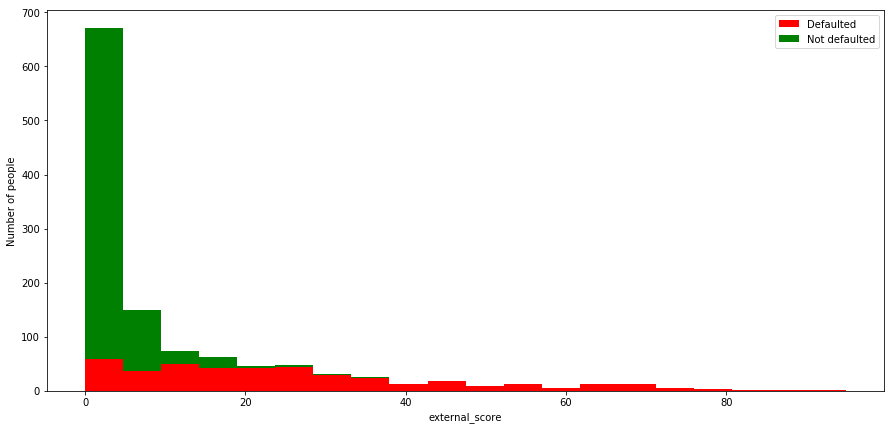

In [137]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['external_score'], df[df['target'] == 0]['external_score']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('external_score')
plt.ylabel('Number of people')
plt.legend();

C:\Users\Brendan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Brendan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


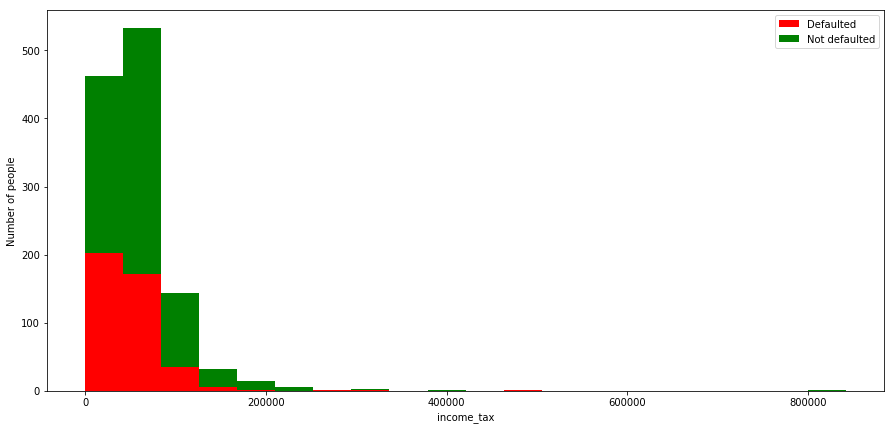

In [13]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['income_tax'], df[df['target'] == 0]['income_tax']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('income_tax')
plt.ylabel('Number of people')
plt.legend();

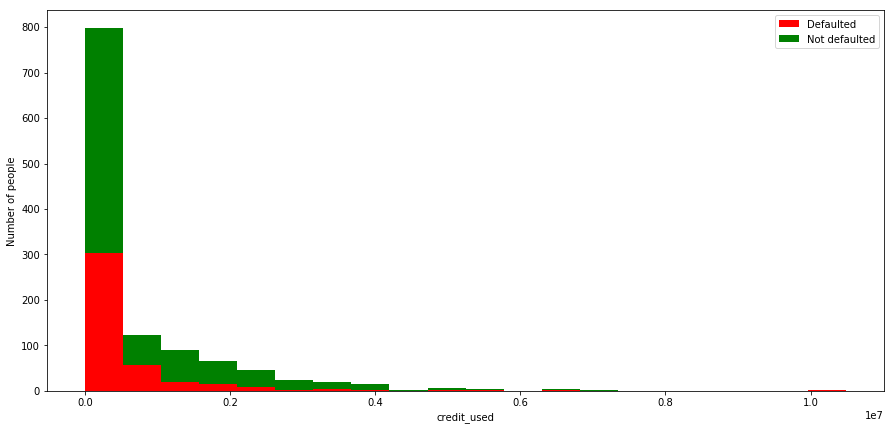

In [14]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_used'], df[df['target'] == 0]['credit_used']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_used')
plt.ylabel('Number of people')
plt.legend();

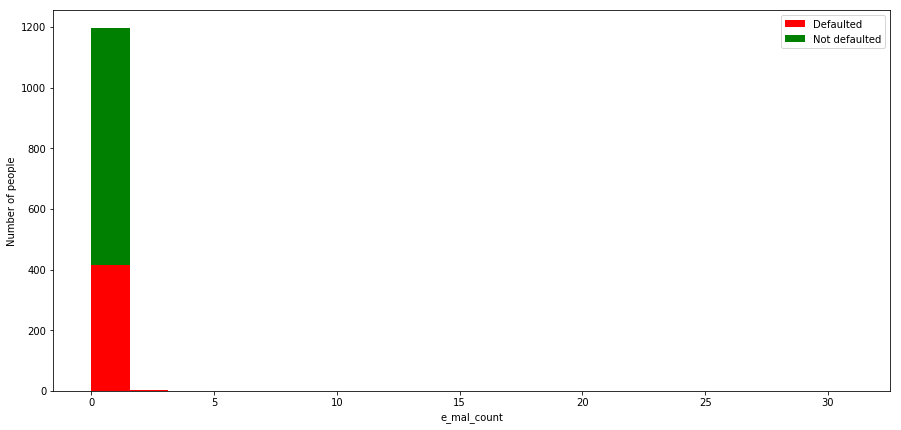

In [15]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['e_mal_count'], df[df['target'] == 0]['e_mal_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('e_mal_count')
plt.ylabel('Number of people')
plt.legend();

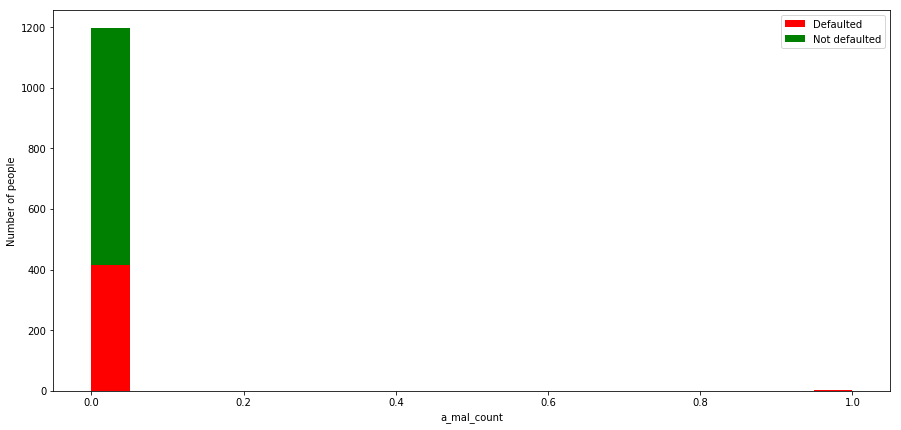

In [16]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['a_mal_count'], df[df['target'] == 0]['a_mal_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('a_mal_count')
plt.ylabel('Number of people')
plt.legend();

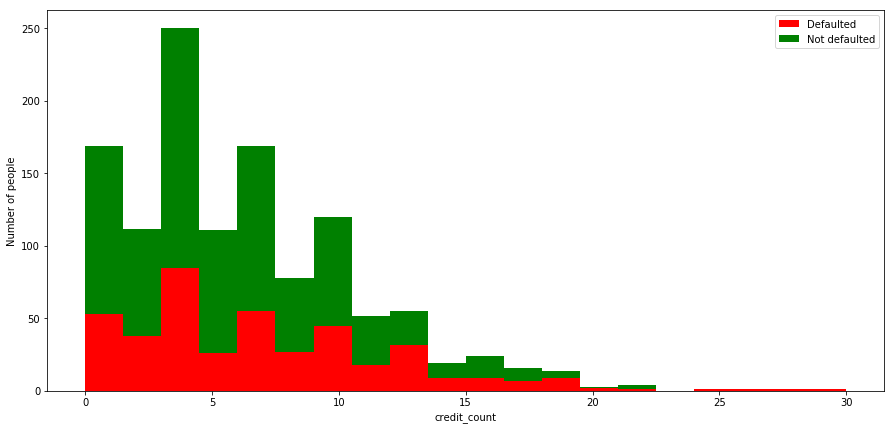

In [17]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_count'], df[df['target'] == 0]['credit_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_count')
plt.ylabel('Number of people')
plt.legend();

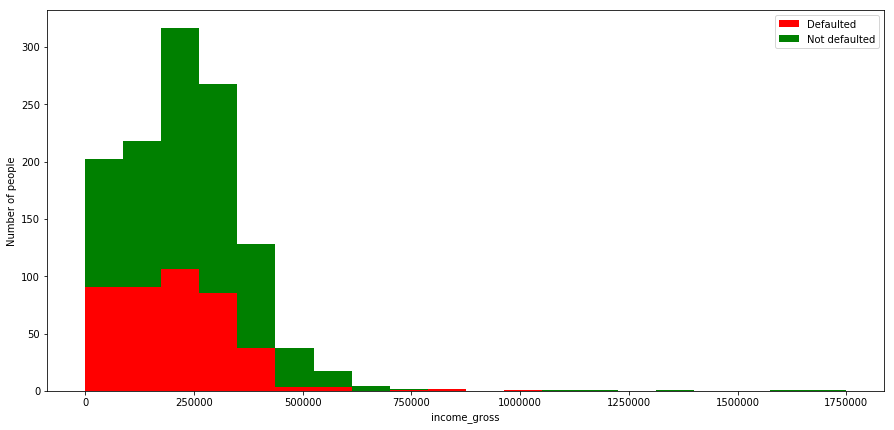

In [18]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['income_gross'], df[df['target'] == 0]['income_gross']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('income_gross')
plt.ylabel('Number of people')
plt.legend();

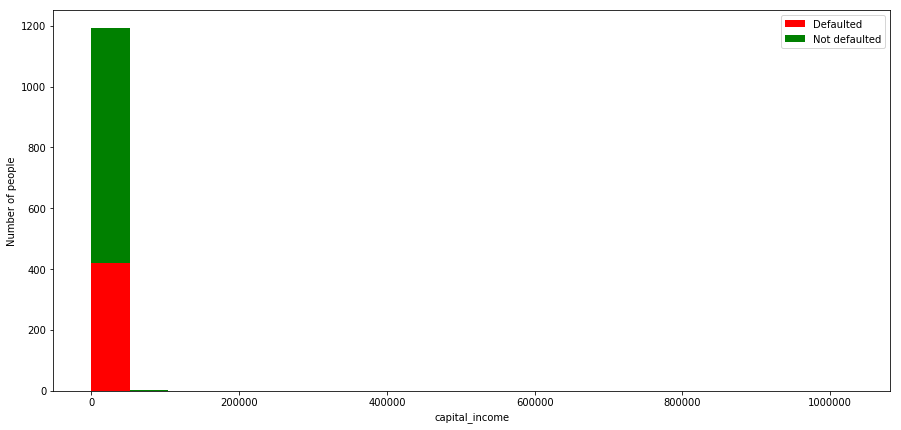

In [19]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['capital_income'], df[df['target'] == 0]['capital_income']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('capital_income')
plt.ylabel('Number of people')
plt.legend();

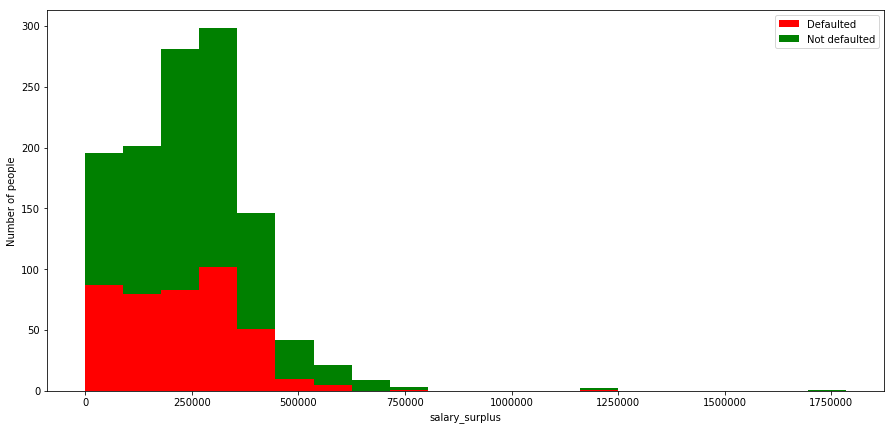

In [20]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['salary_surplus'], df[df['target'] == 0]['salary_surplus']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('salary_surplus')
plt.ylabel('Number of people')
plt.legend();

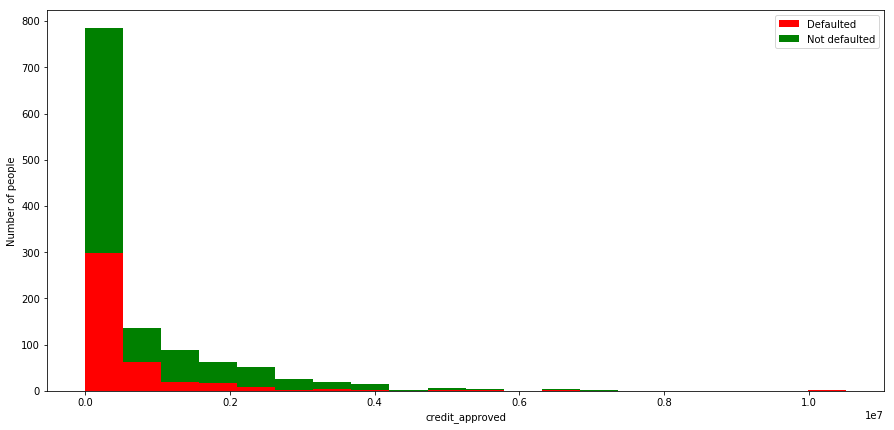

In [21]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_approved'], df[df['target'] == 0]['credit_approved']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_approved')
plt.ylabel('Number of people')
plt.legend();

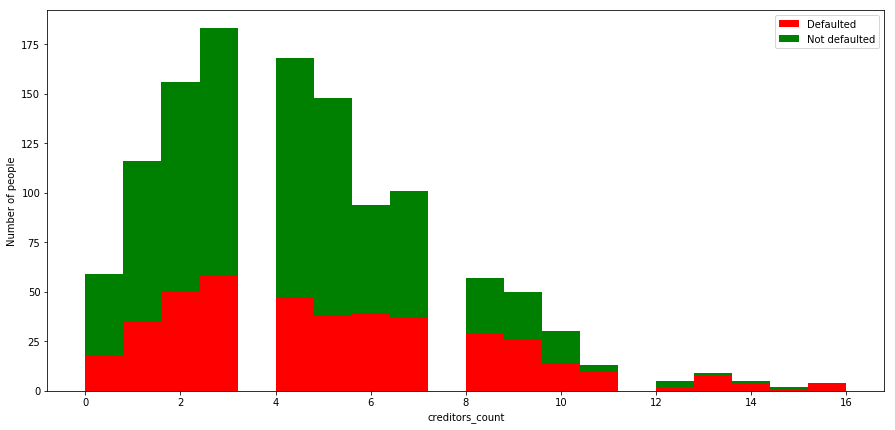

In [22]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['creditors_count'], df[df['target'] == 0]['creditors_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('creditors_count')
plt.ylabel('Number of people')
plt.legend();

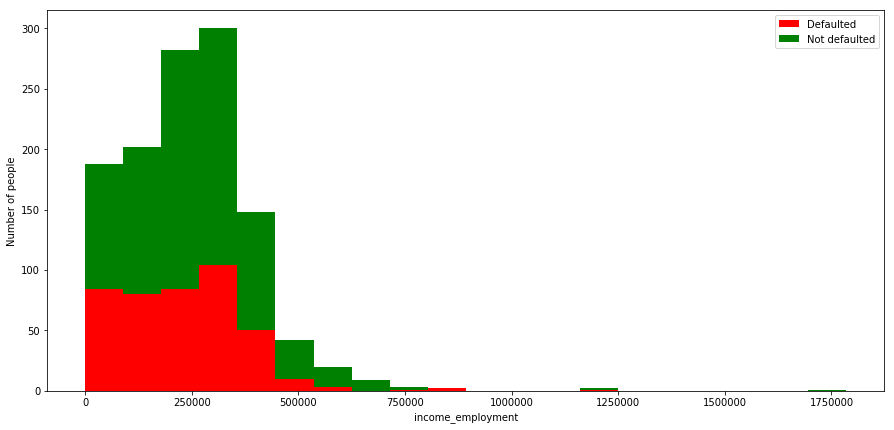

In [23]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['income_employment'], df[df['target'] == 0]['income_employment']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('income_employment')
plt.ylabel('Number of people')
plt.legend();

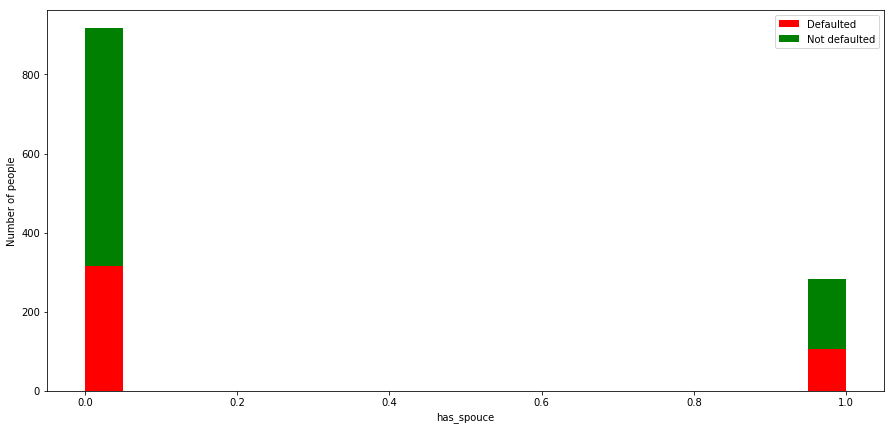

In [24]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['has_spouce'], df[df['target'] == 0]['has_spouce']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('has_spouce')
plt.ylabel('Number of people')
plt.legend();

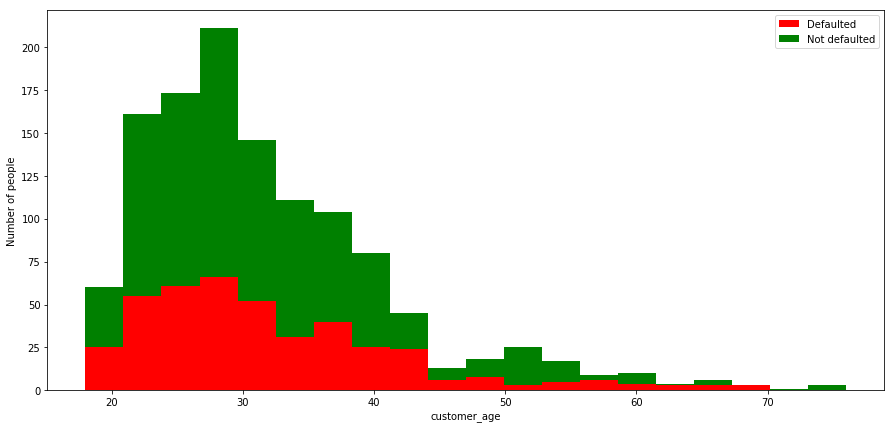

In [25]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['customer_age'], df[df['target'] == 0]['customer_age']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('customer_age')
plt.ylabel('Number of people')
plt.legend();

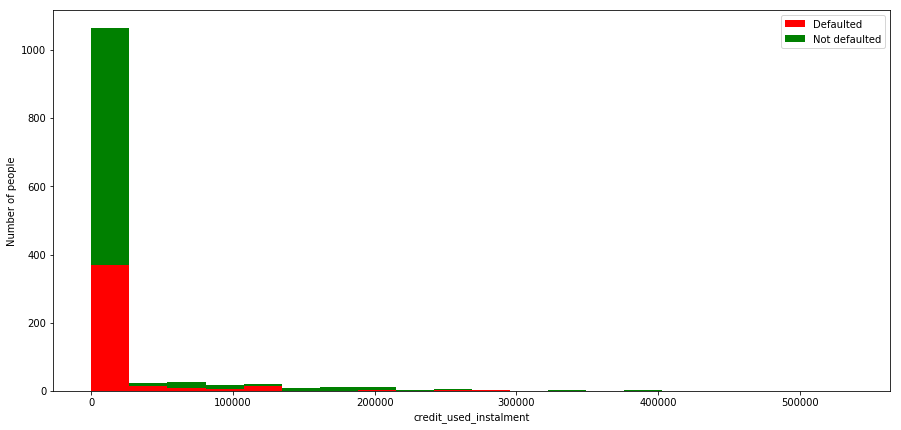

In [26]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_used_instalment'], df[df['target'] == 0]['credit_used_instalment']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_used_instalment')
plt.ylabel('Number of people')
plt.legend();

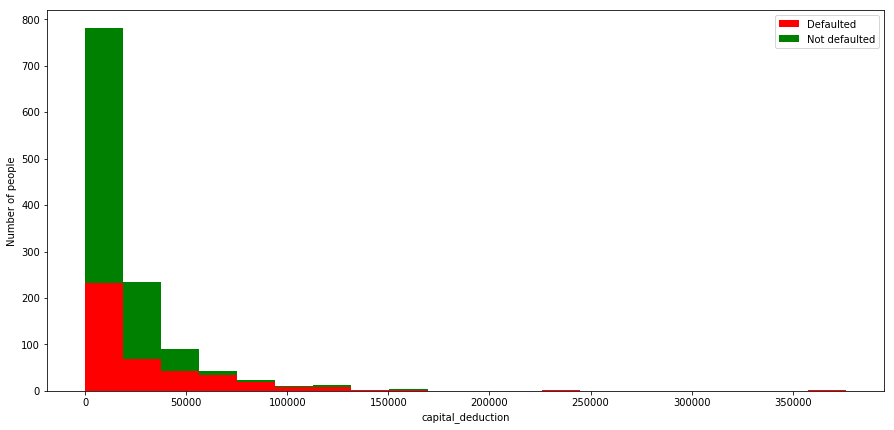

In [27]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['capital_deduction'], df[df['target'] == 0]['capital_deduction']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('capital_deduction')
plt.ylabel('Number of people')
plt.legend();

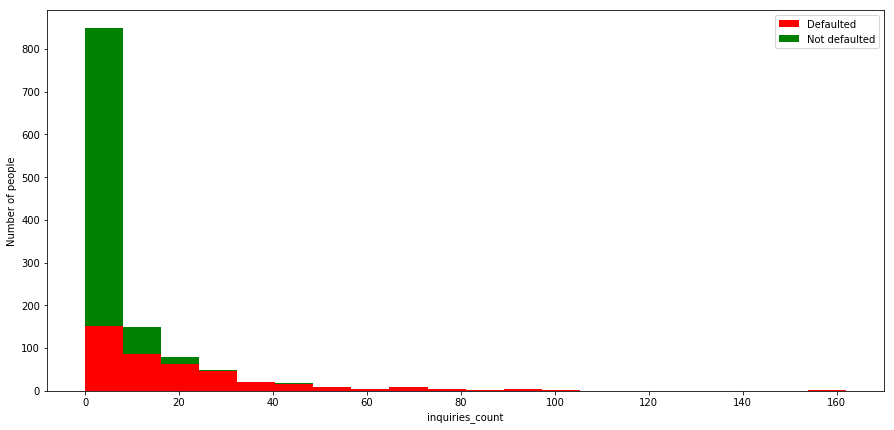

In [28]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['inquiries_count'], df[df['target'] == 0]['inquiries_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('inquiries_count')
plt.ylabel('Number of people')
plt.legend();

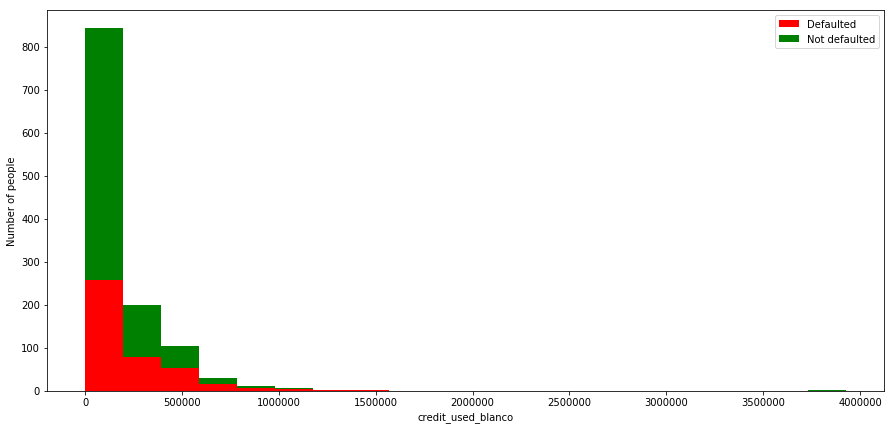

In [29]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_used_blanco'], df[df['target'] == 0]['credit_used_blanco']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_used_blanco')
plt.ylabel('Number of people')
plt.legend();

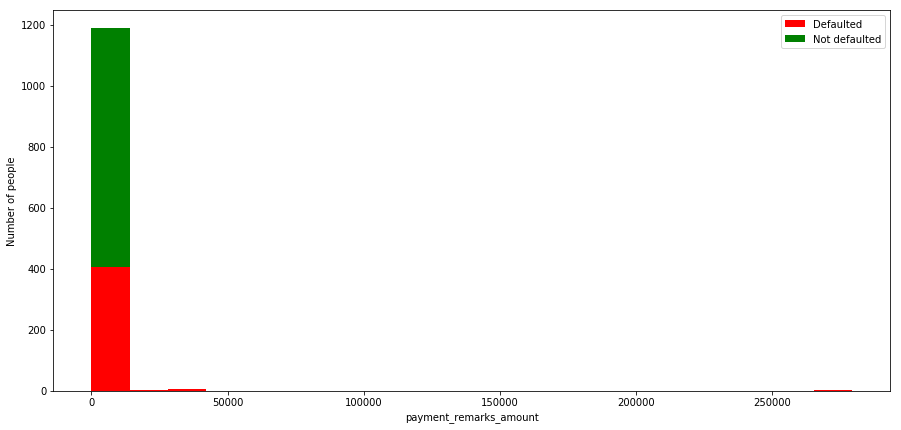

In [30]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['payment_remarks_amount'], df[df['target'] == 0]['payment_remarks_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('payment_remarks_amount')
plt.ylabel('Number of people')
plt.legend();

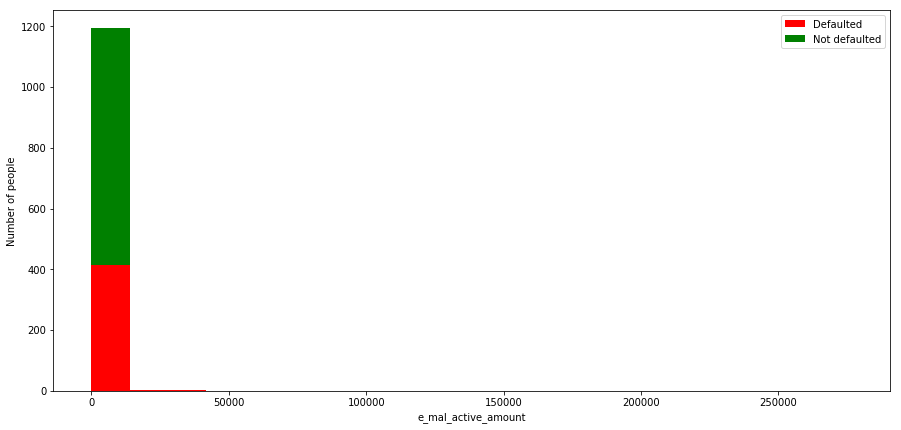

In [31]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['e_mal_active_amount'], df[df['target'] == 0]['e_mal_active_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('e_mal_active_amount')
plt.ylabel('Number of people')
plt.legend();

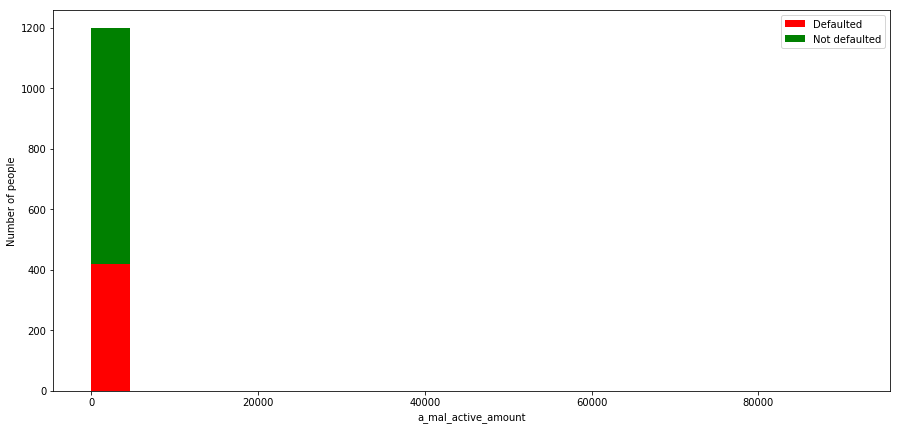

In [32]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['a_mal_active_amount'], df[df['target'] == 0]['a_mal_active_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('a_mal_active_amount')
plt.ylabel('Number of people')
plt.legend();

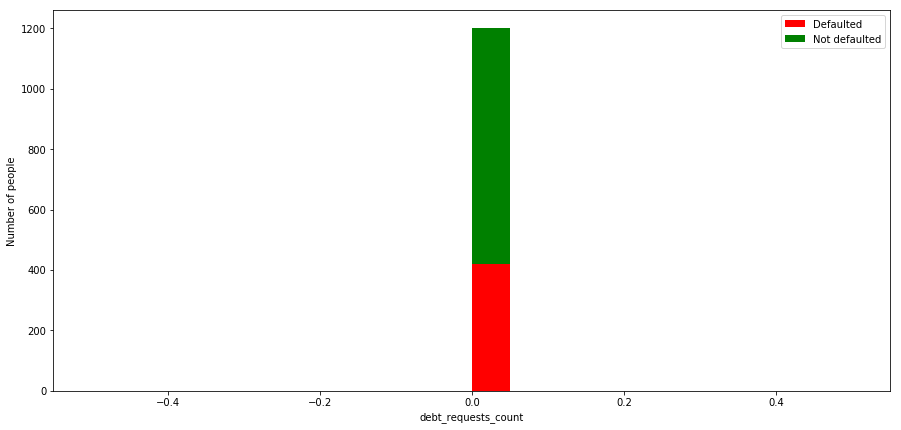

In [33]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['debt_requests_count'], df[df['target'] == 0]['debt_requests_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('debt_requests_count')
plt.ylabel('Number of people')
plt.legend();

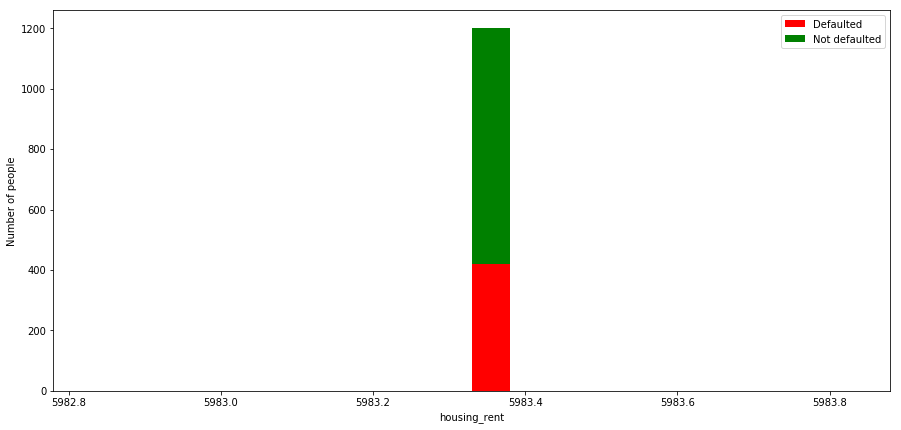

In [34]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['housing_rent'], df[df['target'] == 0]['housing_rent']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('housing_rent')
plt.ylabel('Number of people')
plt.legend();

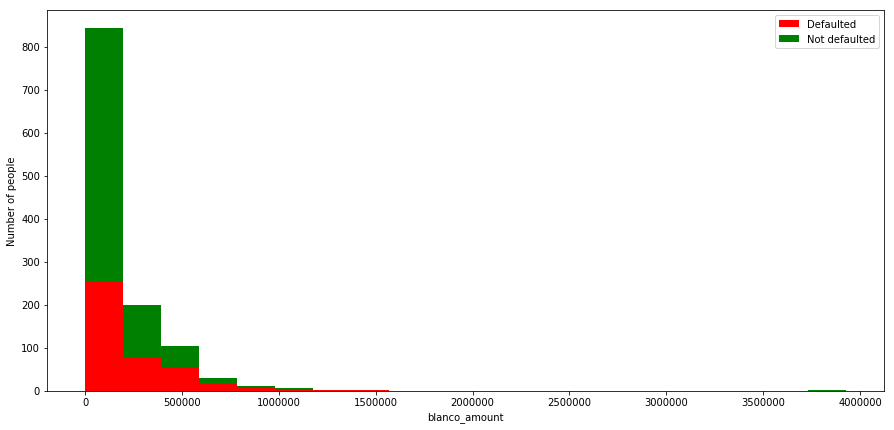

In [35]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['blanco_amount'], df[df['target'] == 0]['blanco_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('blanco_amount')
plt.ylabel('Number of people')
plt.legend();

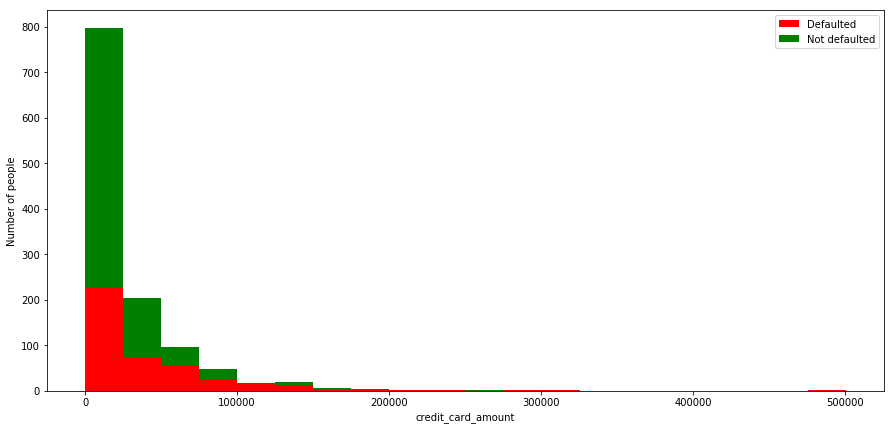

In [36]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_card_amount'], df[df['target'] == 0]['credit_card_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_card_amount')
plt.ylabel('Number of people')
plt.legend();

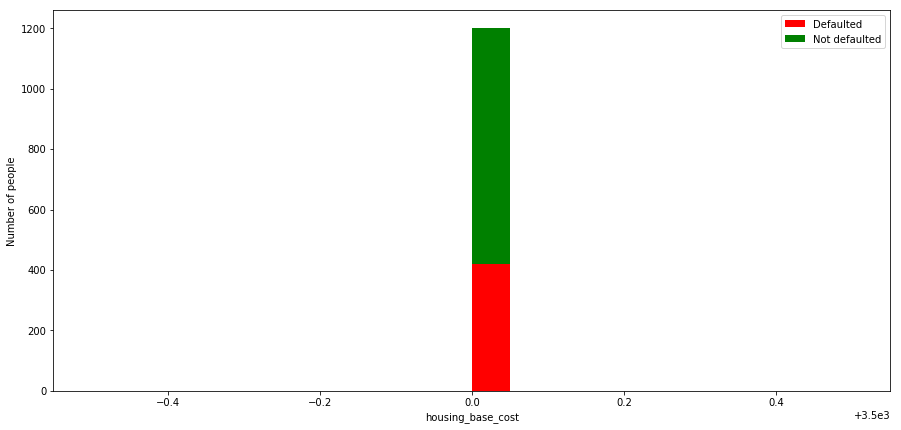

In [37]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['housing_base_cost'], df[df['target'] == 0]['housing_base_cost']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('housing_base_cost')
plt.ylabel('Number of people')
plt.legend();

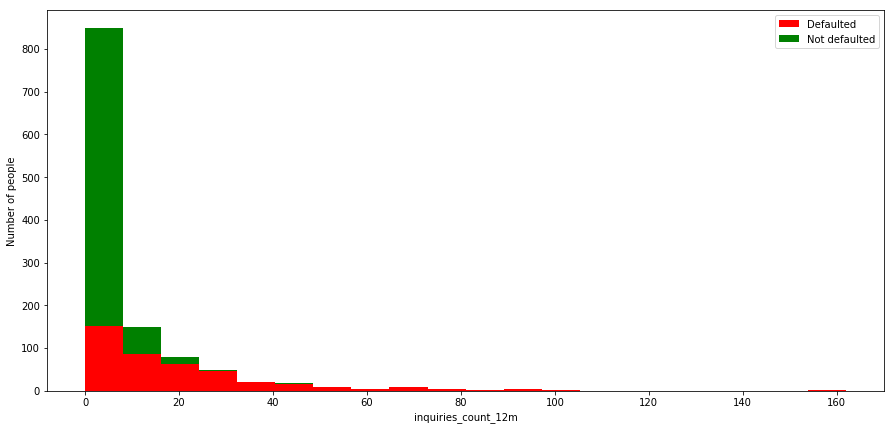

In [38]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['inquiries_count_12m'], df[df['target'] == 0]['inquiries_count_12m']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('inquiries_count_12m')
plt.ylabel('Number of people')
plt.legend();

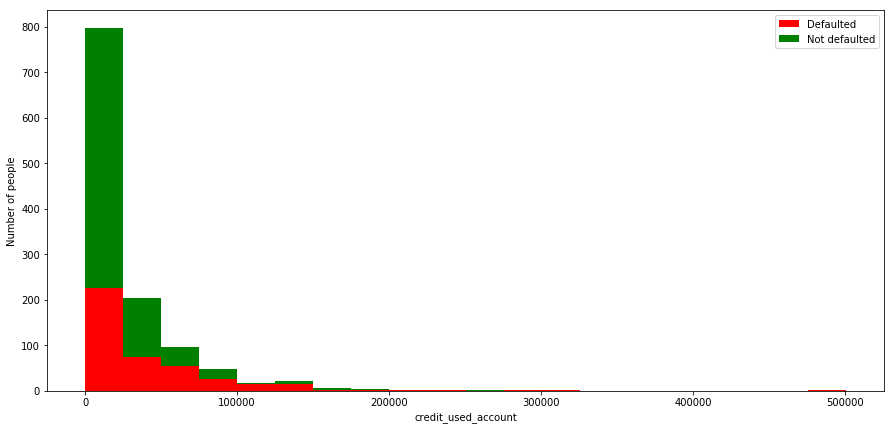

In [39]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['credit_used_account'], df[df['target'] == 0]['credit_used_account']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('credit_used_account')
plt.ylabel('Number of people')
plt.legend();

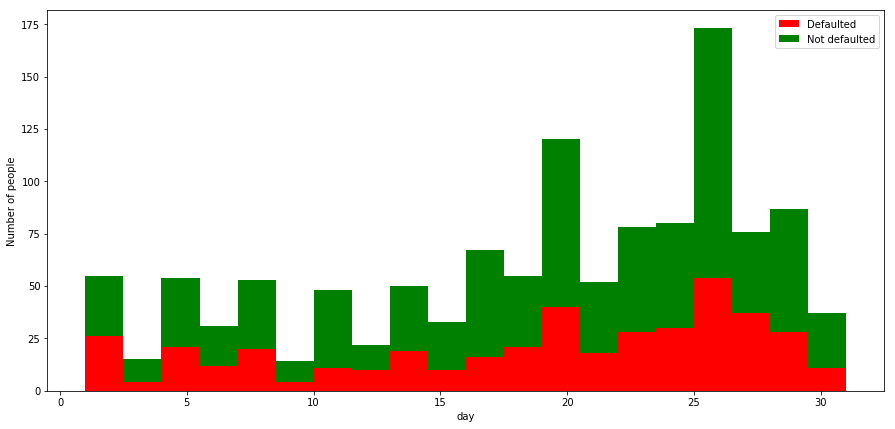

In [40]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['day'], df[df['target'] == 0]['day']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('day')
plt.ylabel('Number of people')
plt.legend();

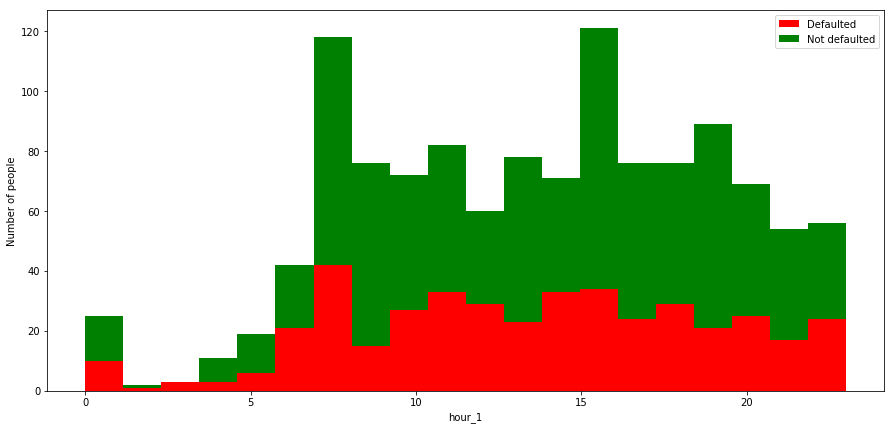

In [41]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['hour_1'], df[df['target'] == 0]['hour_1']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('hour_1')
plt.ylabel('Number of people')
plt.legend();

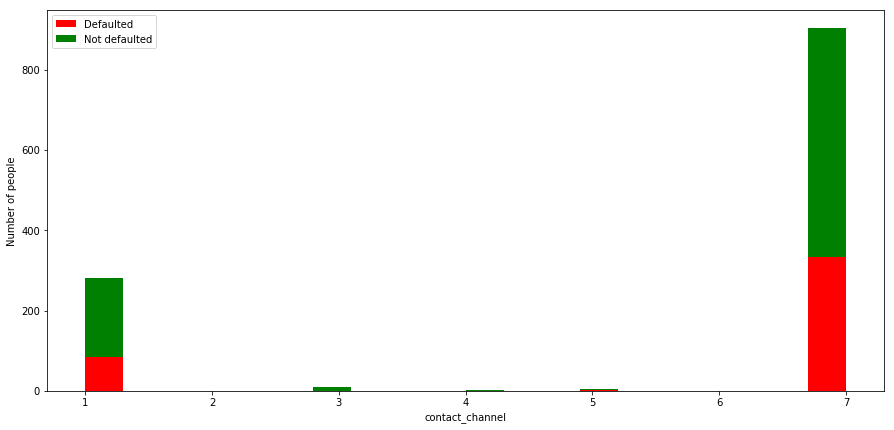

In [42]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['contact_channel'], df[df['target'] == 0]['contact_channel']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('contact_channel')
plt.ylabel('Number of people')
plt.legend();

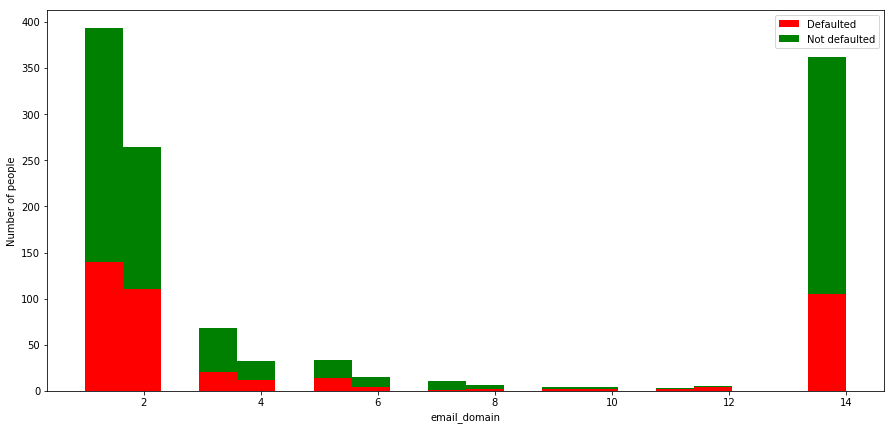

In [43]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['email_domain'], df[df['target'] == 0]['email_domain']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('email_domain')
plt.ylabel('Number of people')
plt.legend();

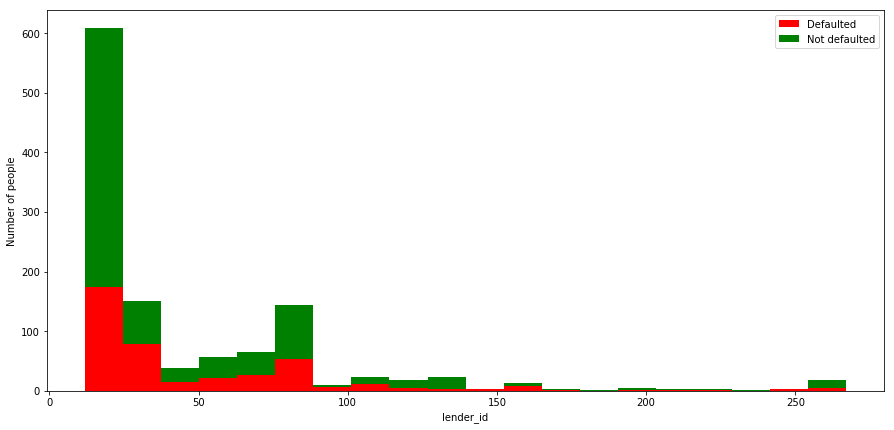

In [44]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['lender_id'], df[df['target'] == 0]['lender_id']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('lender_id')
plt.ylabel('Number of people')
plt.legend();

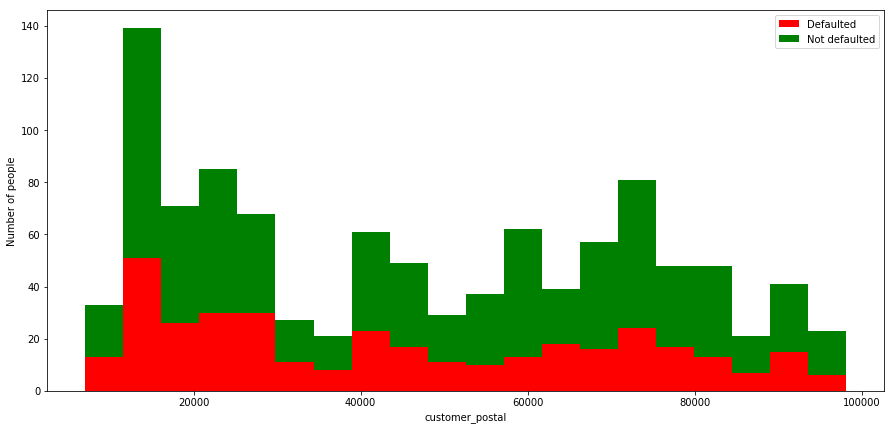

In [45]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['customer_postal'], df[df['target'] == 0]['customer_postal']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('customer_postal')
plt.ylabel('Number of people')
plt.legend();

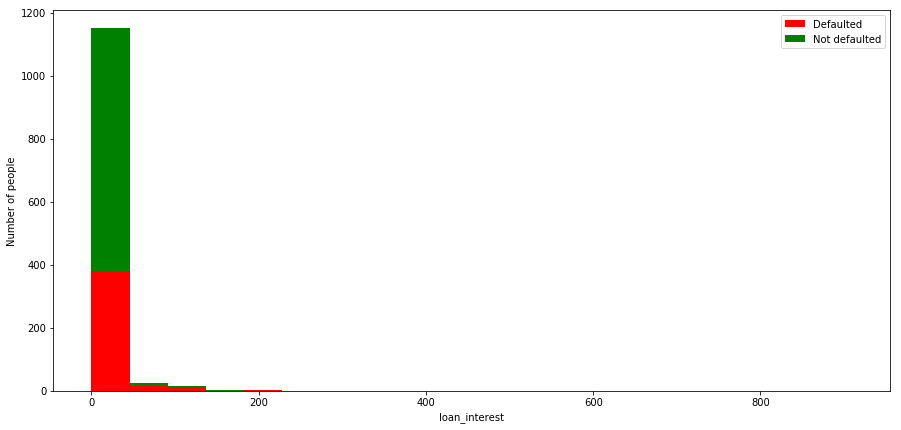

In [46]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['loan_interest'], df[df['target'] == 0]['loan_interest']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('loan_interest')
plt.ylabel('Number of people')
plt.legend();

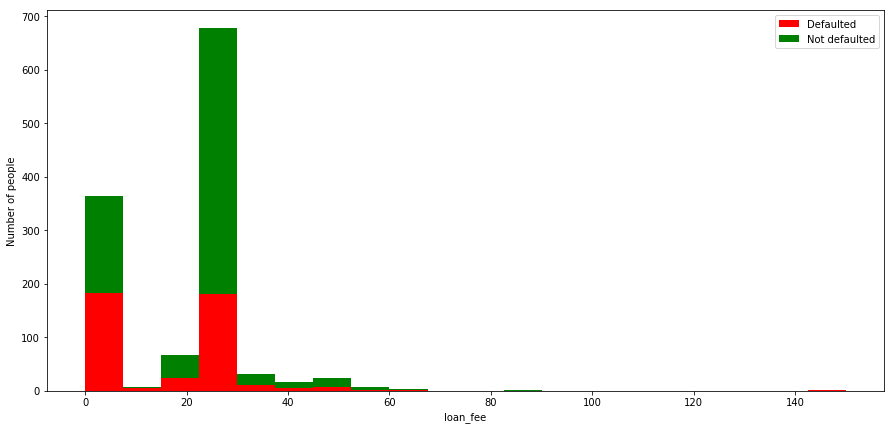

In [47]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['loan_fee'], df[df['target'] == 0]['loan_fee']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('loan_fee')
plt.ylabel('Number of people')
plt.legend();

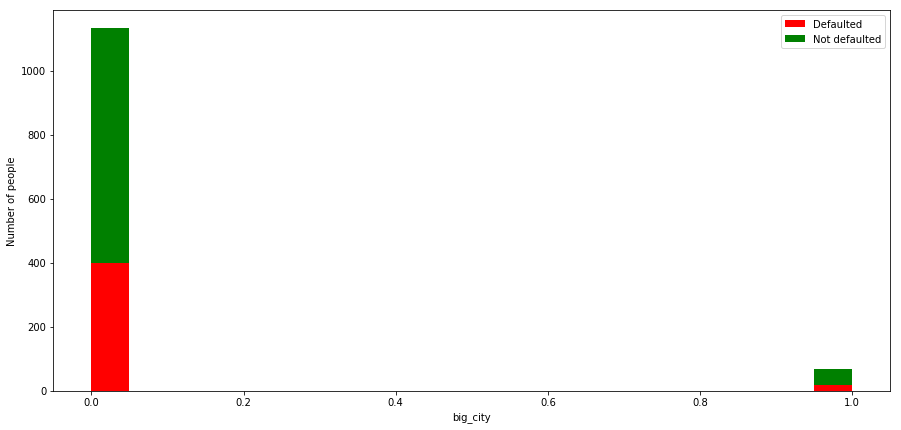

In [48]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['big_city'].astype(float), df[df['target'] == 0]['big_city'].astype(float)], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('big_city')
plt.ylabel('Number of people')
plt.legend();

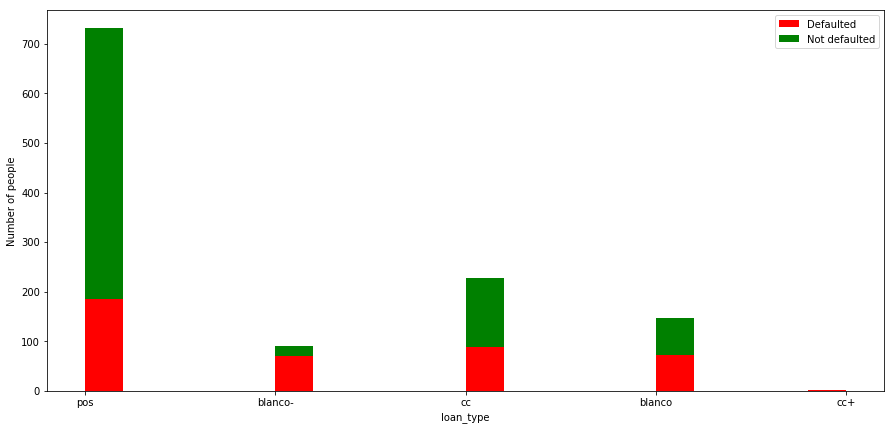

In [49]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['loan_type'].dropna(), df[df['target'] == 0]['loan_type'].dropna()], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('loan_type')
plt.ylabel('Number of people')
plt.legend();

The above considerations reveal the following: Some features are, or should be, straightforward categorical. These include 'has_spouce','loan_type', and 'big_city' (the 'has_spouce' one has just two categories, so may in fact safely be left as a float). 

The 'id' feature should simply be an index which contains no information. It can therefore be dropped.

The 'debt_request_count','housing_rent', and 'housing_base_cost' feature attain no more than one value and provide no information; they may hence be dropped. 

The 'day' and 'hour_1' features appear to be the day of the month and time of the day of the application respectively. These are thus cyclic features which may potentially have a very non-linear relationship to the target (e.g. default spike at a particular time of the day and then decrease again). This could prove a problem for the linear logistic regression, but a tree-based gradient boost model should handle it. In any case, the histograms indicate that the relationship of both features with the target happens to be roughly linear (with defaults decreasing with time and increasing with day). I therefore leave these features unaltered.

The 'contact_channel', 'email_domain', 'lender_id', 'customer_postal', 'e_mal_count', 'a_mal_count', 'capital_income',  'payment_remarks_amount', 'e_mal_active_amount', and 'a_mal_active_amount' features warrant closer consideration; see below.

The rest of the features should work out fine remaining straightforward continuous features.

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


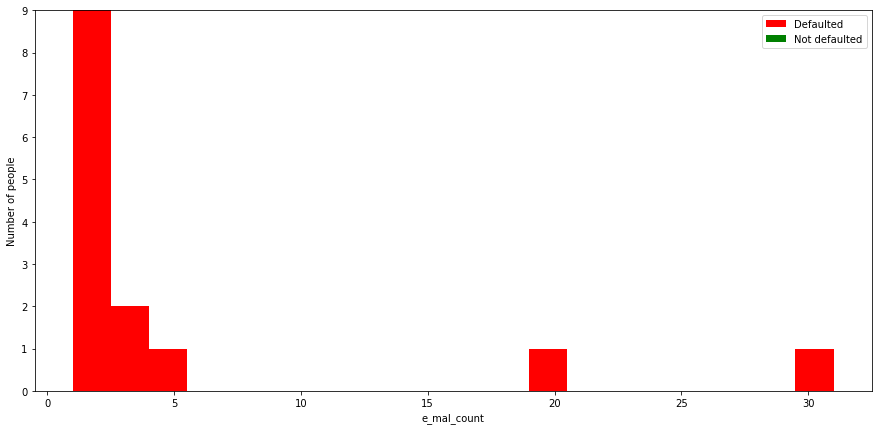

In [50]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1][df['e_mal_count']>0]['e_mal_count'], df[df['target'] == 0][df['e_mal_count']>0]['e_mal_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('e_mal_count')
plt.ylabel('Number of people')
plt.legend();

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


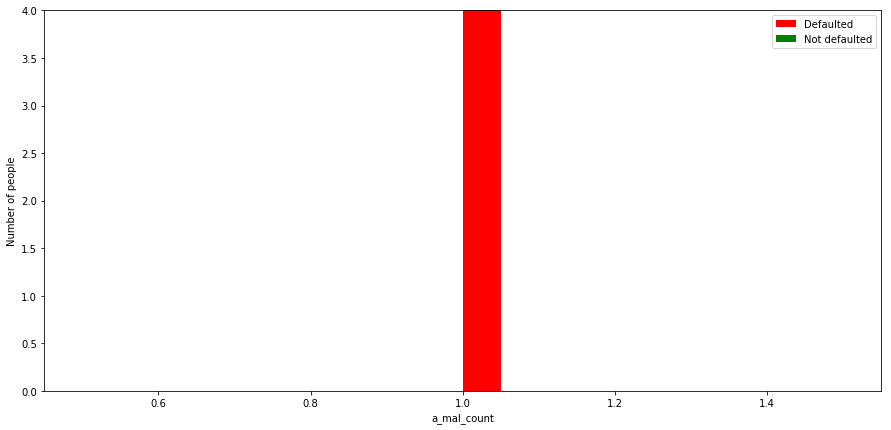

In [51]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1][df['a_mal_count']>0]['a_mal_count'], df[df['target'] == 0][df['a_mal_count']>0]['a_mal_count']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('a_mal_count')
plt.ylabel('Number of people')
plt.legend();

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


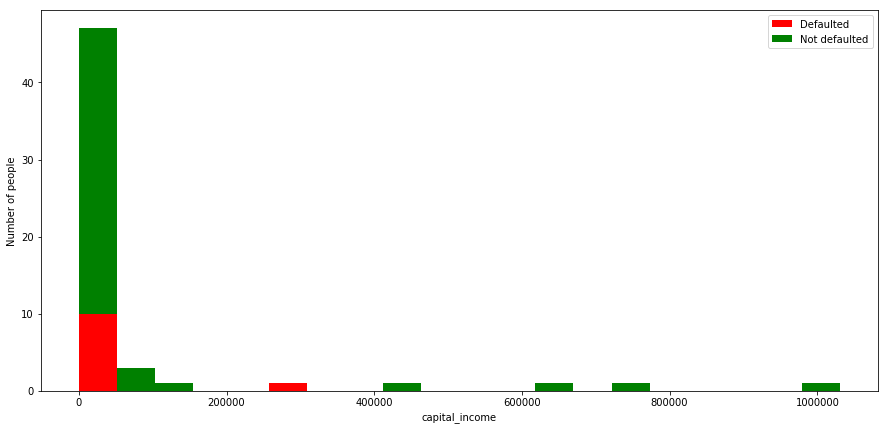

In [52]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1][df['capital_income']>0]['capital_income'], df[df['target'] == 0][df['capital_income']>0]['capital_income']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('capital_income')
plt.ylabel('Number of people')
plt.legend();

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


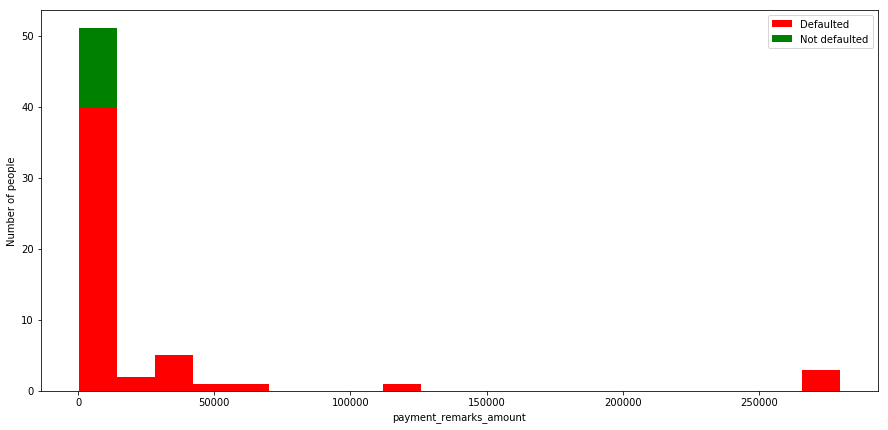

In [53]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1][df['payment_remarks_amount']>0]['payment_remarks_amount'], df[df['target'] == 0][df['payment_remarks_amount']>0]['payment_remarks_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('payment_remarks_amount')
plt.ylabel('Number of people')
plt.legend();

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


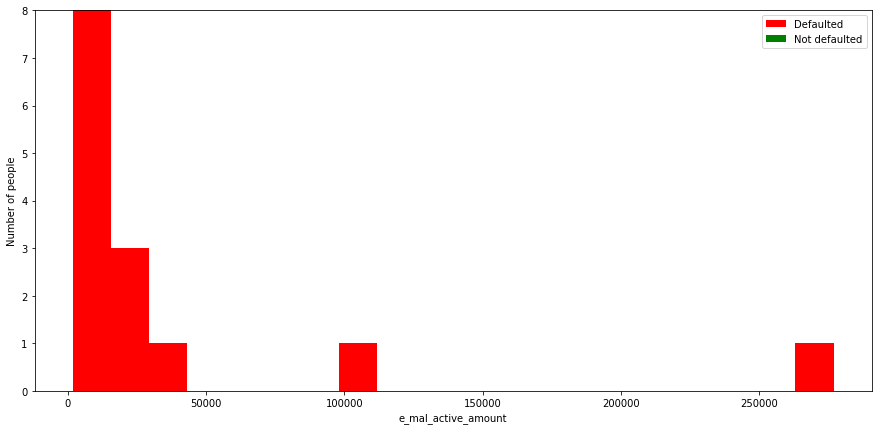

In [54]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1][df['e_mal_active_amount']>0]['e_mal_active_amount'], df[df['target'] == 0][df['e_mal_active_amount']>0]['e_mal_active_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('e_mal_active_amount')
plt.ylabel('Number of people')
plt.legend();

C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


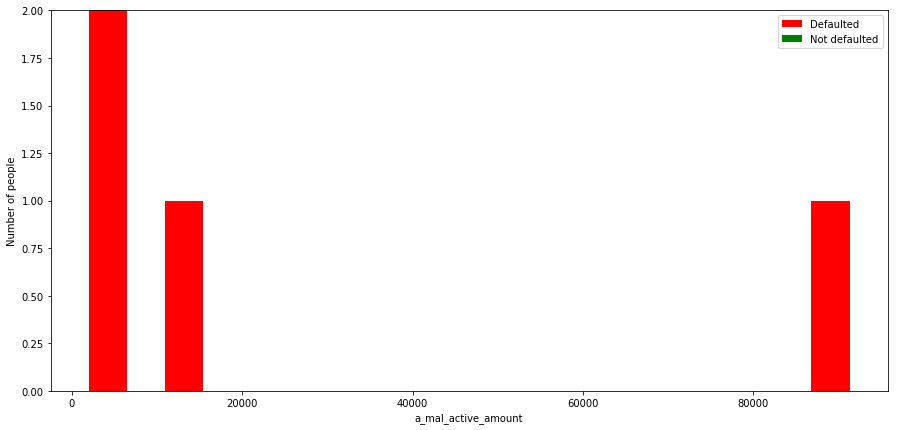

In [55]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1][df['a_mal_active_amount']>0]['a_mal_active_amount'], df[df['target'] == 0][df['a_mal_active_amount']>0]['a_mal_active_amount']], 
         stacked=True, color = ['r','g'],
         bins = 20, label = ['Defaulted','Not defaulted'])
plt.xlabel('a_mal_active_amount')
plt.ylabel('Number of people')
plt.legend();

In [56]:
df.loan_type.value_counts()

pos        731
cc         228
blanco     147
blanco-     91
cc+          2
Name: loan_type, dtype: int64

In [57]:
df.contact_channel.value_counts()

7.0    903
1.0    281
3.0      9
5.0      5
4.0      2
Name: contact_channel, dtype: int64

In [58]:
df.email_domain.value_counts()

1.0     393
14.0    362
2.0     264
3.0      68
5.0      33
4.0      32
6.0      15
7.0      11
8.0       6
12.0      5
9.0       4
10.0      4
11.0      3
Name: email_domain, dtype: int64

In [59]:
df.lender_id.value_counts()

13.0     461
77.0     106
18.0      89
25.0      83
17.0      37
58.0      27
74.0      24
38.0      22
78.0      22
33.0      19
56.0      19
34.0      17
264.0     16
70.0      13
113.0     12
32.0      11
39.0      10
63.0      10
155.0     10
20.0      10
129.0     10
36.0       9
86.0       8
130.0      8
60.0       6
117.0      6
102.0      6
124.0      5
12.0       5
72.0       5
        ... 
167.0      1
71.0       1
111.0      1
234.0      1
230.0      1
87.0       1
254.0      1
67.0       1
150.0      1
243.0      1
158.0      1
245.0      1
262.0      1
215.0      1
68.0       1
199.0      1
213.0      1
183.0      1
205.0      1
157.0      1
108.0      1
15.0       1
177.0      1
106.0      1
200.0      1
216.0      1
59.0       1
50.0       1
44.0       1
76.0       1
Name: lender_id, Length: 95, dtype: int64

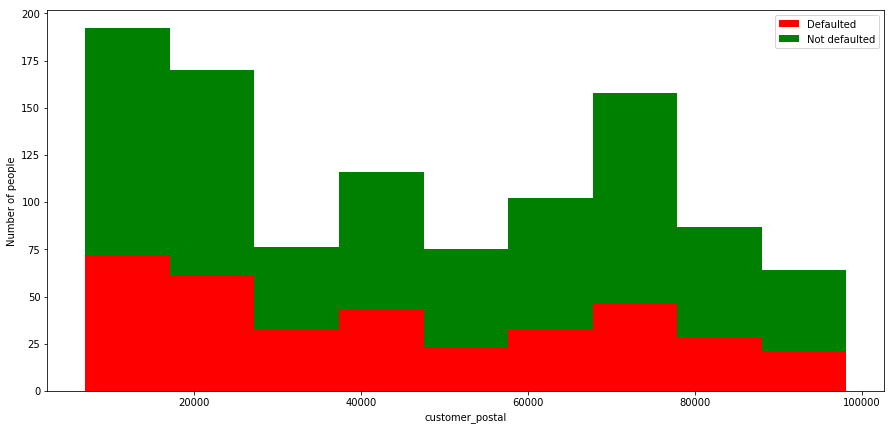

In [60]:
figure = plt.figure(figsize=(15, 7))
plt.hist([df[df['target'] == 1]['customer_postal'], df[df['target'] == 0]['customer_postal']], 
         stacked=True, color = ['r','g'],
         bins = 9, label = ['Defaulted','Not defaulted'])
plt.xlabel('customer_postal')
plt.ylabel('Number of people')
plt.legend();

We may now conclude the following about the closer considered features.

'contact_channel','email_domain': Have few enough categories to work out as straightforward categorical variables.

'lender_id': Should be a categorical feature, but has too many categories (which poses a risk of overfitting). I will therefore leave the 15 most common categories be and collect the rest into an "other" category. 

'customer_postal': The postal code of the customer should be a categorical feature, but definitely has too many categories as is. I opt for selecting the first digit of the postal code, which gives us 9 categories each representing a rather large geographical region. Besides the issue of the amount of categories, one might possibly worry about a PR backlash in case particular neighbourhoods turned out to be significatnly selected against by the model (consider e.g. https://en.wikipedia.org/wiki/Disparate_impact).

'e_mal_count','a_mal_count','e_mal_active_amount','a_mal_active_amount': Any non-zero amount leads to a default prediction, so I make these categorical with categories "zero" and "non-zero". 

'capital_income', 'payment_remarks_amount': Should work out as straightforward continuous variables.  

## Data cleaning and feature engineering

We now implement the feature engineering discussed above. I did not spot any clearly unreasonable data points (for instance customer ages of hundreds of years) to be removed. However, there are a few missing values to take care of. Luckily almost all of these are missing 'customer_postal' values, so after introducing an 'unknown' category there, we may simply drop the examples with missing values without much loss.

We first drop non-informative features.

In [61]:
data = df.drop(['debt_requests_count','housing_rent','housing_base_cost'],axis=1)

We now process the 'customer_postal' feature.

In [62]:
def process_customer_postal(code):
    if code == None:
        new = 'unknown'
    else:
        new = str(code)[0]
    return new

In [63]:
data['processed_customer_postal'] = data.apply(lambda row: process_customer_postal(row['customer_postal']),axis=1)

In [64]:
data.drop(['customer_postal'],axis=1,inplace=True)

Drop examples with missing values.

In [65]:
data.dropna(inplace=True)

In [66]:
data.reset_index(inplace=True)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 38 columns):
index                        1198 non-null int64
id                           1198 non-null object
external_score               1198 non-null float64
income_tax                   1198 non-null float64
credit_used                  1198 non-null float64
e_mal_count                  1198 non-null float64
a_mal_count                  1198 non-null float64
credit_count                 1198 non-null float64
income_gross                 1198 non-null float64
capital_income               1198 non-null float64
salary_surplus               1198 non-null float64
credit_approved              1198 non-null float64
creditors_count              1198 non-null float64
income_employment            1198 non-null float64
has_spouce                   1198 non-null float64
customer_age                 1198 non-null float64
credit_used_instalment       1198 non-null float64
capital_deduction            

We process the 'e_mal_count','a_mal_count','e_mal_active_amount', and 'a_mal_active_amount' features.

In [68]:
def process_mal(mal):
    if mal == 0.0:
        new = 'zero'
    else:
        new = 'nonzero'
    return new

In [69]:
for feature in ['e_mal_count','a_mal_count','e_mal_active_amount','a_mal_active_amount']:
    data['processed_'+feature] = data.apply(lambda row: process_mal(row[feature]),axis=1)

In [70]:
for feature in ['e_mal_count','a_mal_count','e_mal_active_amount','a_mal_active_amount']:
    data.drop([feature],axis=1,inplace=True)

We process the 'lender_id' feature.

In [71]:
def process_lender_id(lender):
    if lender in [13.0,77.0,18.0,25.0,17.0,58.0,74.0,38.0,78.0,33.0,56.0,34.0,264.0,70.0,113.0]:
        new = str(lender)
    else:
        new = 'other'
    return new

In [72]:
data['processed_lender_id'] = data.apply(lambda row: process_lender_id(row['lender_id']),axis=1)

In [73]:
data.drop(['lender_id'],axis=1,inplace=True)

We process the 'big_city' feature.

In [74]:
data['processed_big_city'] = data.apply(lambda row: str(row['big_city']),axis=1)

In [75]:
data.drop(['big_city'],axis=1,inplace=True)

We process the 'contact_channel' feature.

In [76]:
data['processed_contact_channel'] = data.apply(lambda row: str(row['contact_channel']),axis=1)

In [77]:
data.drop(['contact_channel'],axis=1,inplace=True)

We process the 'email_domain' feature.

In [78]:
data['processed_email_domain'] = data.apply(lambda row: str(row['email_domain']),axis=1)

In [79]:
data.drop(['email_domain'],axis=1,inplace=True)

We drop the 'id' feature.

In [80]:
data.drop(['id'],axis=1,inplace=True)

We do a one-hot encoding of categorical features.

In [81]:
data = pd.get_dummies(data)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 86 columns):
index                                    1198 non-null int64
external_score                           1198 non-null float64
income_tax                               1198 non-null float64
credit_used                              1198 non-null float64
credit_count                             1198 non-null float64
income_gross                             1198 non-null float64
capital_income                           1198 non-null float64
salary_surplus                           1198 non-null float64
credit_approved                          1198 non-null float64
creditors_count                          1198 non-null float64
income_employment                        1198 non-null float64
has_spouce                               1198 non-null float64
customer_age                             1198 non-null float64
credit_used_instalment                   1198 non-null float64
capital_deduc

## Models and metrics

Below we implement the gradient boosting XGBoost model (known for superior performance on structured data), with a simple logistic regression model as a benchmark. Since the objective is to produce good probability estimates, I choose to optimize for the binary logistic loss function. As a primary validation score to compare different models and parameter choices I choose the Brier score (again with the objective to predict probabilities in mind), but also consider accuracy and area under the ROC curve. In addition to plain XGBoost models for various parameter choices, I also try out calibrated ones and in the end settle for one calibrated using the isotonic method.

Since I want to tune model and parameter choices and also want to quantify the end result I first need to do a train/validation/test split. 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], 1), data.target, test_size=0.2, random_state=42)

In [84]:
X_train_part, X_validation, y_train_part, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

First we establish the logistic regression benchmark.

In [85]:
logres = LogisticRegression()

In [86]:
logres.fit(X_train,y_train)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

We evaluate the logistic regression model using a calibration curve, the Brier score, accuracy and area under the ROC curve.

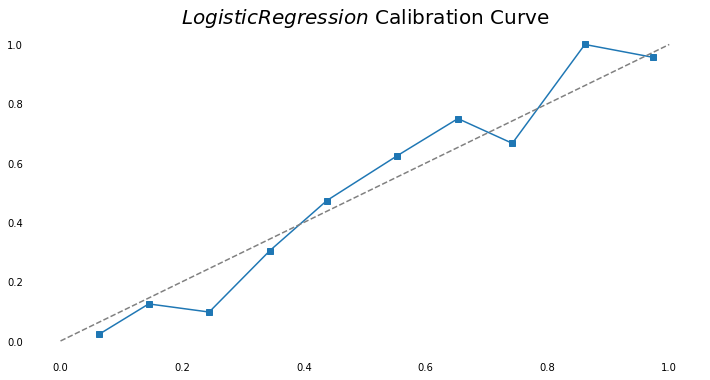

In [87]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, logres.predict_proba(X_test)[:,1], n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$LogisticRegression$ Calibration Curve", fontsize=20); pass

In [88]:
brier_score_loss(y_test,logres.predict(X_test))

0.15416666666666667

In [89]:
accuracy_score(y_test,logres.predict(X_test))

0.8458333333333333

In [90]:
roc_auc_score(y_test,logres.predict(X_test))

0.7883504492939666

We now start creating the main model. This will be an XGBoost model where we try out different parameter choices and pick the best one using a grid search. The result is again evaluated via the calibration curve, the Brier score, accuracy, and area under the ROC curve (this time on the validation set because these results will be used in picking the final model).

We then calibrate the above model using the sigmoid and the isotonic methods respectively, and evaluate in the same way.

In [91]:
xgb = xgboost.XGBClassifier(objective='binary:logistic',seed=42)

In [92]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1,2,4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [93]:
cross_validation = StratifiedKFold(n_splits=5)

In [94]:
grid_search = GridSearchCV(xgb, scoring='brier_score_loss',param_grid=parameters,cv=cross_validation,verbose=1)

In [95]:
grid_search.fit(X_train_part,y_train_part)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:  6.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9], 'min_child_weight': [1, 2, 4], 'subsample': [0.8, 0.9, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='brier_score_loss', verbose=1)

In [96]:
grid_search.best_score_

-0.08599836461887618

Im am not sure what the score above is about; clearly a Brier score should not take on negative values. In any case, the Brier scores later computed are reasonable, so whatever error is occurring here, it should not be consequential. 

In [97]:
best_parameters_brier = grid_search.best_params_
print(best_parameters_brier)

{'colsample_bytree': 0.9, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 0.9}


In [98]:
xgb_model_brier = xgboost.XGBClassifier(objective='binary:logistic',learning_rate=0.01,seed=42,**best_parameters_brier)

In [99]:
xgb_model_brier.fit(X_train_part,y_train_part)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.9)

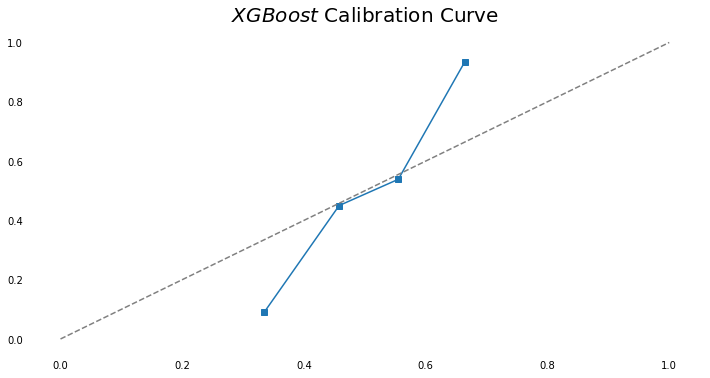

In [100]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_validation, xgb_model_brier.predict_proba(X_validation)[:,1], n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$XGBoost$ Calibration Curve", fontsize=20); pass

In [101]:
brier_score_loss(y_validation,xgb_model_brier.predict(X_validation))

0.15416666666666667

In [102]:
accuracy_score(y_validation,xgb_model_brier.predict(X_validation))

0.8458333333333333

In [103]:
roc_auc_score(y_validation,xgb_model_brier.predict(X_validation))

0.8309241094475994

Now for the sigmoid calibrated model.

In [104]:
xgb_model_calibrated_sigmoid = xgboost.XGBClassifier(objective='binary:logistic',learning_rate=0.01,seed=42,**best_parameters_brier)

In [105]:
xgb_model_calibrated_sigmoid = CalibratedClassifierCV(xgb_model_calibrated_sigmoid,method='sigmoid')

In [106]:
xgb_model_calibrated_sigmoid.fit(X_train_part,y_train_part)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.9),
            cv='warn', method='sigmoid')

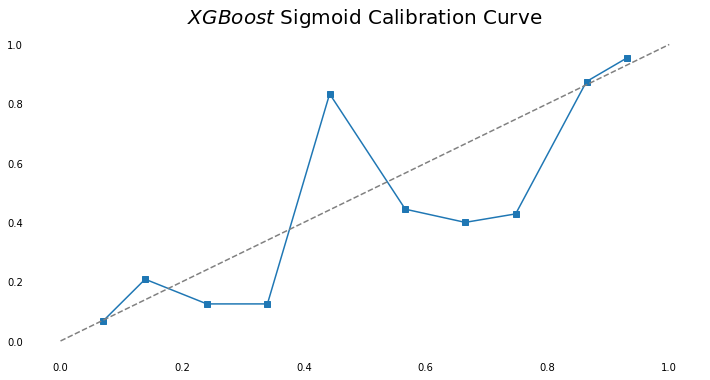

In [138]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_validation, xgb_model_calibrated_sigmoid.predict_proba(X_validation)[:,1], n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$XGBoost$ Sigmoid Calibration Curve", fontsize=20); pass

In [108]:
brier_score_loss(y_validation,xgb_model_calibrated_sigmoid.predict(X_validation))

0.15

In [109]:
accuracy_score(y_validation,xgb_model_calibrated_sigmoid.predict(X_validation))

0.85

In [110]:
roc_auc_score(y_validation,xgb_model_calibrated_sigmoid.predict(X_validation))

0.8385574157386237

And finally the isotonic calibrated model.

In [111]:
xgb_model_calibrated_isotonic = xgboost.XGBClassifier(objective='binary:logistic',learning_rate=0.01,seed=42,**best_parameters_brier)

In [112]:
xgb_model_calibrated_isotonic = CalibratedClassifierCV(xgb_model_calibrated_isotonic,method='isotonic')

In [113]:
xgb_model_calibrated_isotonic.fit(X_train_part,y_train_part)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.9),
            cv='warn', method='isotonic')

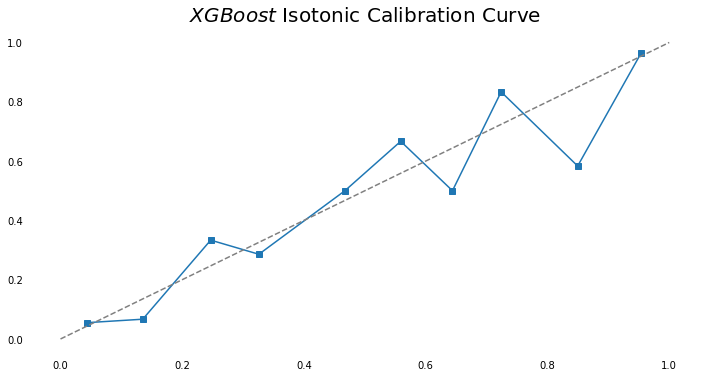

In [139]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_validation, xgb_model_calibrated_isotonic.predict_proba(X_validation)[:,1], n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$XGBoost$ Isotonic Calibration Curve", fontsize=20); pass

In [115]:
brier_score_loss(y_validation,xgb_model_calibrated_isotonic.predict(X_validation))

0.1375

In [116]:
accuracy_score(y_validation,xgb_model_calibrated_isotonic.predict(X_validation))

0.8625

In [117]:
roc_auc_score(y_validation,xgb_model_calibrated_isotonic.predict(X_validation))

0.8507633306291025

According to all the available metrics, the calibrated model using the isotonic method performs the best. The isotonic method is known to have a risk of overfitting on small data sets, but since we are obtaining good results on a separate validation set, this does not seem to be the case here. 

We will now as our final model train an isotonically calibrated XGBoost model from scratch with the optimal parameter schoices, smaller step size and on the entire training set. Finally we evaluate on the test set.

In [118]:
xgb_model = xgboost.XGBClassifier(objective='binary:logistic',learning_rate=0.01,seed=42,**best_parameters_brier)

In [119]:
xgb_model = CalibratedClassifierCV(xgb_model,method='isotonic')

In [120]:
xgb_model.fit(X_train,y_train)

C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.9),
            cv='warn', method='isotonic')

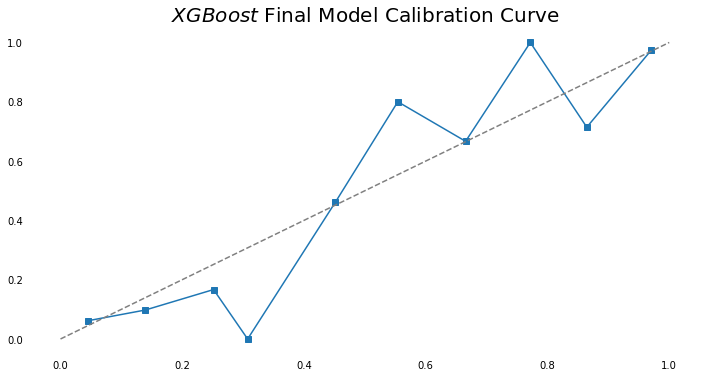

In [141]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, xgb_model.predict_proba(X_test)[:,1], n_bins=10)
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.title("$XGBoost$ Final Model Calibration Curve", fontsize=20); pass

In [122]:
brier_score_loss(y_test,xgb_model.predict(X_test))

0.10416666666666667

In [123]:
accuracy_score(y_test,xgb_model.predict(X_test))

0.8958333333333334

In [124]:
roc_auc_score(y_test,xgb_model.predict(X_test))

0.8602374839537869